## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from re import sub

import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

from sklearn.model_selection import train_test_split 

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
from wordcloud import WordCloud, STOPWORDS

In [4]:
from nltk import word_tokenize
from nltk.util import ngrams

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [5]:
# Opening JSON file 
f = open("complaints-2021-05-14_08_16.json")
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [6]:
# Inspect the dataframe to understand the given data.

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [7]:
#print the column names

for col in df.columns:
    print(col)

_index
_type
_id
_score
_source.tags
_source.zip_code
_source.complaint_id
_source.issue
_source.date_received
_source.state
_source.consumer_disputed
_source.product
_source.company_response
_source.company
_source.submitted_via
_source.date_sent_to_company
_source.company_public_response
_source.sub_product
_source.timely
_source.complaint_what_happened
_source.sub_issue
_source.consumer_consent_provided


In [8]:
#Assign new column names

new_names = {"_index": "_index",
"_type": "_type",
"_id": "_id",
"_score": "_score",
"_source.tags": "tags",
"_source.zip_code": "zip_code",
"_source.complaint_id": "complaint_id",
"_source.issue": "issue",
"_source.date_received": "date_received",
"_source.state": "state",
"_source.consumer_disputed": "consumer_disputed",
"_source.product": "product",
"_source.company_response": "company_response",
"_source.company": "company",
"_source.submitted_via": "submitted_via",
"_source.date_sent_to_company": "date_sent_to_company",
"_source.company_public_response": "company_public_response",
"_source.sub_product": "sub_product",
"_source.timely": "timely",
"_source.complaint_what_happened": "complaint_what_happened",
"_source.sub_issue": "sub_issue",
"_source.consumer_consent_provided": "consumer_consent_provided"}

df.rename(new_names, axis=1, inplace=True)

In [9]:
#Assign nan in place of blanks in the complaints column
df["complaint_what_happened"].replace("", np.nan, inplace=True)

In [10]:
#Remove all rows where complaints column is nan
df = df[~df["complaint_what_happened"].isnull()]

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [11]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
    
    text = text.lower()                               #make the text lowercase
    text = sub("\[.*\]", "", text)                    #remove text in square brackets
    text = sub(r'[^\w\s]','',text)                    #remove punctuation
    text = sub(r'[a-zA-Z]*\d+[a-zA-Z]*', '', text)    #remove words containing numbers
    
    return text.strip()

In [12]:
#Write your function to Lemmatize the texts

def lemmatize_text(text):
    text = clean_text(text)
    doc = nlp(text)    
        
    return " ".join([token.lemma_ for token in doc])

In [13]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 

df_clean = pd.DataFrame()

df_clean["complaint_what_happened"] = df["complaint_what_happened"]
df_clean["complaint_lemma"] = df_clean["complaint_what_happened"].apply(lemmatize_text)

In [14]:
df_clean

,complaint_what_happened,complaint_lemma
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in and be tell b...
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent a...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it i...
...,...,...
78303,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx I call chas my xxxx xxxx...
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for yr I ve have...


In [15]:
#Write your function to extract the POS tags 

def get_singular_nouns(text):
    doc = nlp(text)
    
    return " ".join([str(token) for token in doc if token.tag_=="NN"])

In [16]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean["complaint_POS_removed"] = df_clean["complaint_lemma"].apply(get_singular_nouns)

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




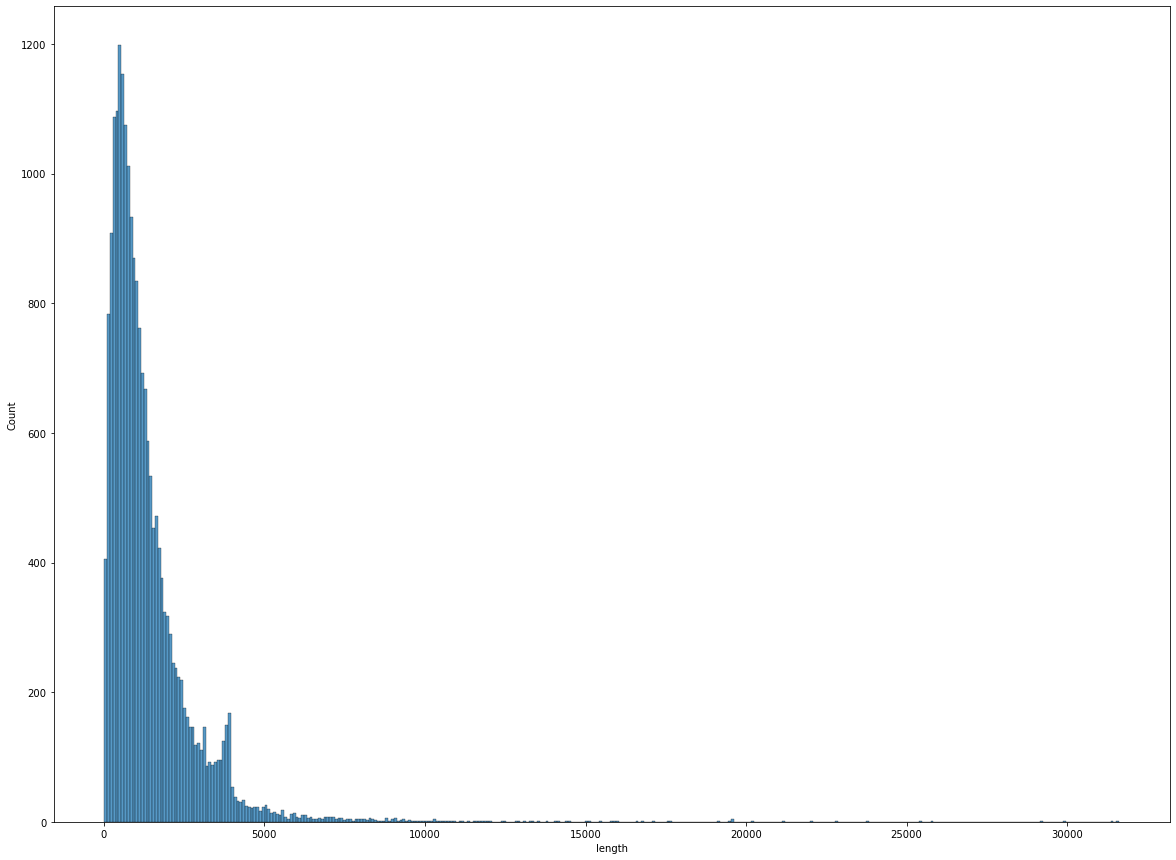

In [17]:
# Write your code here to visualise the data according to the 'Complaint' character length

df_clean["length"] = df_clean["complaint_what_happened"].apply(len)

plt.figure(figsize=(20,15))
sns.histplot(x = df_clean["length"])
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

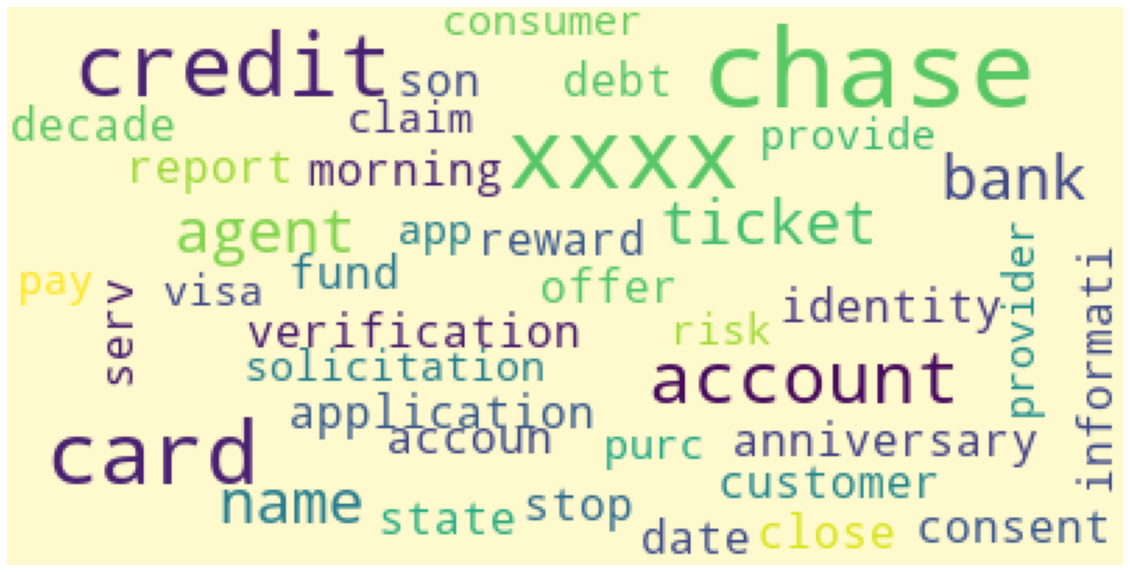

In [18]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

stopwords = set(STOPWORDS)

wordcloud = WordCloud(background_color='lemonchiffon', stopwords=stopwords,max_words=40, max_font_size=40, random_state=42)

fig = plt.figure(figsize=(20,15))
plt.imshow(wordcloud.generate(str(df_clean['complaint_POS_removed'])))
plt.axis('off')
plt.show()

In [19]:
#Removing -PRON- from the text corpus
df_clean['complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [20]:
#Function to find the top n-grams

def top_n_grams(corpus, top, n):
    vec = CountVectorizer(ngram_range=(n,n), stop_words='english')
    bag_of_words = vec.fit_transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    
    freq = pd.Series(sum_words.tolist()[0], index=vec.get_feature_names())
    freq = freq.sort_values(ascending=False).head(top)
    return freq

In [21]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
unigrams = top_n_grams(df_clean["complaint_clean"], 30, 1)

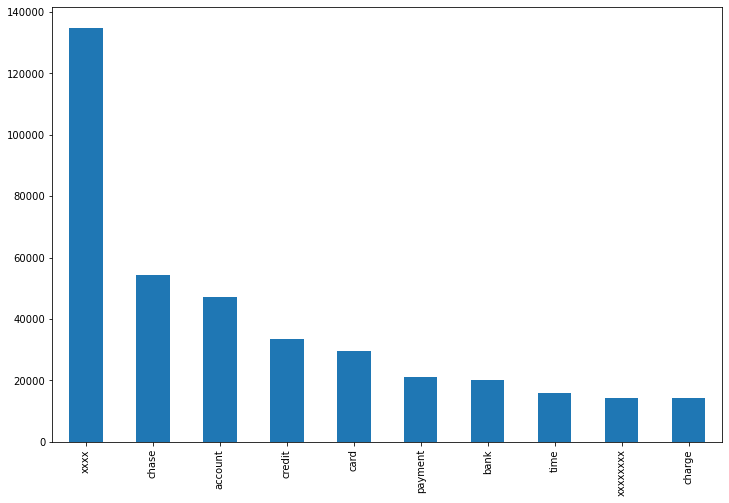

In [22]:
#Print the top 10 words in the unigram frequency
plt.figure(figsize=(12,8))
unigrams.head(10).plot.bar()
plt.show()

In [23]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
bigrams = top_n_grams(df_clean["complaint_clean"], 30, 2)

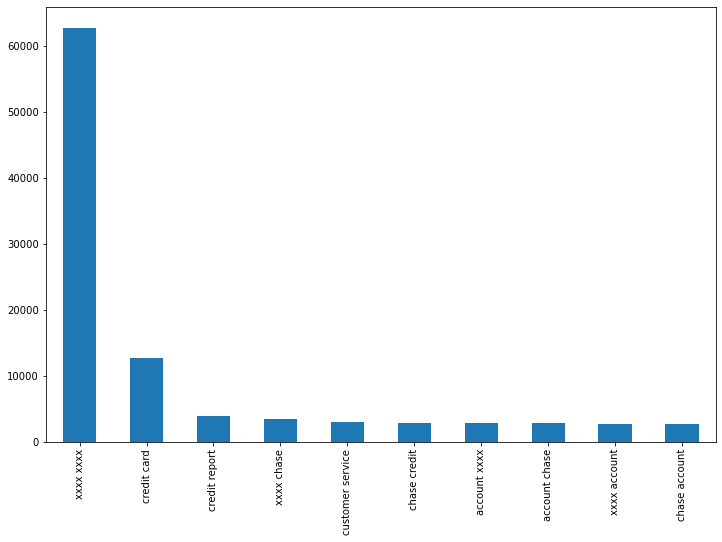

In [24]:
#Print the top 10 words in the bigram frequency
plt.figure(figsize=(12,8))
bigrams.head(10).plot.bar()
plt.show()

In [25]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
trigrams = top_n_grams(df_clean["complaint_clean"], 30, 3)

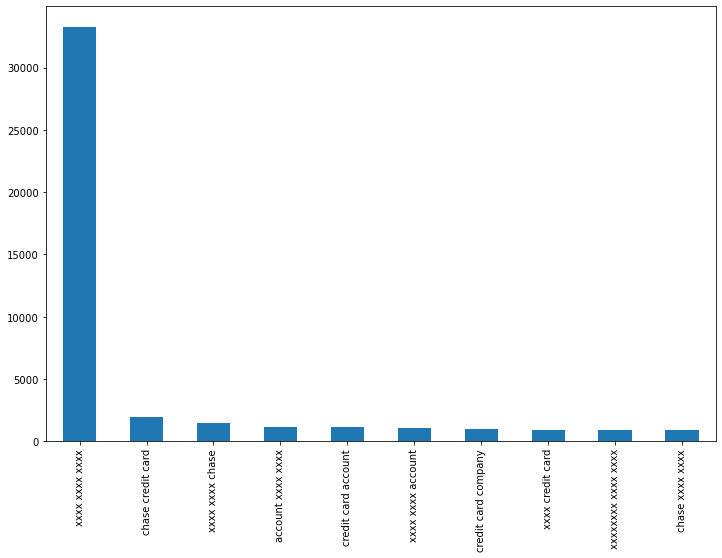

In [26]:
#Print the top 10 words in the trigram frequency
plt.figure(figsize=(12,8))
trigrams.head(10).plot.bar()
plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [27]:
df_clean['complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('xxxx','')

In [28]:
#All masked texts has been removed
df_clean

,complaint_what_happened,complaint_lemma,complaint_POS_removed,length,complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name xxxx stop debt verification state...,486,morning name stop debt verification statement...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in and be tell b...,xxxx xxxx card agent anniversary date agent in...,355,card agent anniversary date agent informatio...
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent a...,chase report application identity consent serv...,224,chase report application identity consent serv...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket ...,xxxx ticket offer ticket reward card informati...,1502,ticket offer ticket reward card information o...
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it i...,son chase account fund chase bank close accoun...,477,son chase account fund chase bank close accoun...
...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,679,chase card customer decade solicitation credit...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx I call chas my xxxx xxxx...,xxxx xxxx visa credit card provider claim purc...,2114,visa credit card provider claim purchase pro...
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer chase bank app chase...,2319,pay risk provide consumer chase bank app chase...
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for yr I ve have...,credit yr chase credit card chase freedom prob...,2171,credit yr chase credit card chase freedom prob...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [29]:
#Write your code here to initialise the TfidfVectorizer 

tfidf = TfidfVectorizer(stop_words="english", max_df=0.95, min_df=2)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [30]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.

dtm = tfidf.fit_transform(df_clean["complaint_clean"])

pd.DataFrame(dtm.toarray(), columns=tfidf.get_feature_names())

,aa,aaarating,aarp,ab,aba,abandonment,abatement,abbreviation,abd,abide,...,yield,yo,yoga,youinv,youth,yr,zip,zipcode,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
21068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
21069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
21070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.146635,0.0,0.0,0.0,0.0


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [31]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [32]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5        #Keeping the number of topics as 5 as it is written in the evaluation rubrics

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [33]:
W = nmf_model.fit_transform(dtm)  # Document-topic matrix
H = nmf_model.components_         # Topic-term matrix

In [34]:
#Print the Top15 words for each of the topics

words = np.array(tfidf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                               columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,chase,fund,deposit,branch,day,checking,number,business,transfer,transaction,customer
Topic 2,card,credit,chase,balance,account,limit,score,year,point,month,offer,purchase,time,application,reason
Topic 3,payment,loan,mortgage,chase,home,month,modification,time,year,rate,property,balance,date,statement,letter
Topic 4,report,inquiry,credit,company,information,reporting,debt,account,identity,bureaus,score,theft,letter,file,inquire
Topic 5,charge,dispute,transaction,chase,fee,merchant,claim,fraud,purchase,email,service,company,time,refund,day


In [35]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

cols = ["Topic " + str(i+1) for i in range(num_topics)]
doc_topic = pd.DataFrame(np.round(W, 2), columns=cols) 
best_topic = np.argmax(doc_topic.values, axis=1)

In [36]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = best_topic

In [37]:
df_clean.head()

,complaint_what_happened,complaint_lemma,complaint_POS_removed,length,complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name xxxx stop debt verification state...,486,morning name stop debt verification statement...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in and be tell b...,xxxx xxxx card agent anniversary date agent in...,355,card agent anniversary date agent informatio...,1
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent a...,chase report application identity consent serv...,224,chase report application identity consent serv...,3
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket ...,xxxx ticket offer ticket reward card informati...,1502,ticket offer ticket reward card information o...,3
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it i...,son chase account fund chase bank close accoun...,477,son chase account fund chase bank close accoun...,0


In [38]:
#Print the first 5 Complaint for each of the Topics
df_clean.groupby('Topic').head(5).sort_values('Topic')

,complaint_what_happened,complaint_lemma,complaint_POS_removed,length,complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name xxxx stop debt verification state...,486,morning name stop debt verification statement...,0
24,mishandling of this account by Chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto xxxx,51,mishandle account auto,0
17,With out notice J.P. Morgan Chase restricted m...,with out notice jp morgan chase restrict my ac...,notice jp account debit card branch customer s...,2277,notice jp account debit card branch customer s...,0
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it i...,son chase account fund chase bank close accoun...,477,son chase account fund chase bank close accoun...,0
27,I opened an account with chase bank on XXXX an...,I open an account with chase bank on xxxx and ...,account code xxxx bonus xxxxxxxx term everythi...,413,account code bonus term everything account ...,0
32,My chase amazon card was declined for a cateri...,my chase amazon card be decline for a catering...,chase amazon card decline catering order place...,1972,chase amazon card decline catering order place...,1
59,I currently have over XXXX Chase Ultimate Rewa...,I currently have over xxxx chase ultimate rewa...,xxxx chase reward point month chase reward acc...,1897,chase reward point month chase reward account...,1
52,My roommate was stealing my Chase debit card a...,my roommate be steal my chase debit card and d...,roommate chase debit card driver money account...,843,roommate chase debit card driver money account...,1
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in and be tell b...,xxxx xxxx card agent anniversary date agent in...,355,card agent anniversary date agent informatio...,1
50,I AM A SENIOR CITIZEN THAT HAS BEEN SCAMMED BY...,I be a senior citizen that have be scamme by s...,citizen company xxxx time share company nothin...,350,citizen company time share company nothing re...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [39]:
#Create the dictionary of Topic names and Topics

Topic_names = {0: "Bank Account services",
              1: "Credit card or prepaid card",
              2: "Mortgage/Loan",
              3: "Theft/Dispute Reporting",
              4: "Others"}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [40]:
df_clean

,complaint_what_happened,complaint_lemma,complaint_POS_removed,length,complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name xxxx stop debt verification state...,486,morning name stop debt verification statement...,Bank Account services
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in and be tell b...,xxxx xxxx card agent anniversary date agent in...,355,card agent anniversary date agent informatio...,Credit card or prepaid card
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent a...,chase report application identity consent serv...,224,chase report application identity consent serv...,Theft/Dispute Reporting
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket ...,xxxx ticket offer ticket reward card informati...,1502,ticket offer ticket reward card information o...,Theft/Dispute Reporting
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it i...,son chase account fund chase bank close accoun...,477,son chase account fund chase bank close accoun...,Bank Account services
...,...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,679,chase card customer decade solicitation credit...,Credit card or prepaid card
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx I call chas my xxxx xxxx...,xxxx xxxx visa credit card provider claim purc...,2114,visa credit card provider claim purchase pro...,Others
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer chase bank app chase...,2319,pay risk provide consumer chase bank app chase...,Theft/Dispute Reporting
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for yr I ve have...,credit yr chase credit card chase freedom prob...,2171,credit yr chase credit card chase freedom prob...,Credit card or prepaid card


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [41]:
#Create the dictionary again of Topic names and Topics

Topic_names = {"Bank Account services": 0,
              "Credit card or prepaid card": 1,
              "Mortgage/Loan": 2,
              "Theft/Dispute Reporting": 3,
              "Others": 4}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [42]:
df_clean

,complaint_what_happened,complaint_lemma,complaint_POS_removed,length,complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name xxxx stop debt verification state...,486,morning name stop debt verification statement...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in and be tell b...,xxxx xxxx card agent anniversary date agent in...,355,card agent anniversary date agent informatio...,1
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent a...,chase report application identity consent serv...,224,chase report application identity consent serv...,3
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket ...,xxxx ticket offer ticket reward card informati...,1502,ticket offer ticket reward card information o...,3
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it i...,son chase account fund chase bank close accoun...,477,son chase account fund chase bank close accoun...,0
...,...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,679,chase card customer decade solicitation credit...,1
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx I call chas my xxxx xxxx...,xxxx xxxx visa credit card provider claim purc...,2114,visa credit card provider claim purchase pro...,4
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer chase bank app chase...,2319,pay risk provide consumer chase bank app chase...,3
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for yr I ve have...,credit yr chase credit card chase freedom prob...,2171,credit yr chase credit card chase freedom prob...,1


In [43]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[["complaint_what_happened", "Topic"]]

In [44]:
training_data

,complaint_what_happened,Topic
1,Good morning my name is XXXX XXXX and I apprec...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,1
10,Chase Card was reported on XX/XX/2019. However...,3
11,"On XX/XX/2018, while trying to book a XXXX XX...",3
14,my grand son give me check for {$1600.00} i de...,0
...,...,...
78303,After being a Chase Card customer for well ove...,1
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",4
78310,I am not familiar with XXXX pay and did not un...,3
78311,I have had flawless credit for 30 yrs. I've ha...,1


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [45]:
#Write your code to get the Vector count
count_vec = CountVectorizer()
X = count_vec.fit_transform(training_data.complaint_what_happened)

#Write your code here to transform the word vector to tf-idf
tfidf = TfidfTransformer()
X_tfidf = tfidf.fit_transform(X)

In [46]:
y = training_data.Topic

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25, random_state=42)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [49]:
# Write your code here to build any 3 models and evaluate them using the required metrics

def show_metrics(y_true, y_pred):
    labels = ["Bank Account services", "Credit card or prepaid card", "Mortgage/Loan", "Theft/Dispute Reporting", "Others"]
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(15,8))
    sns.heatmap(cm, cmap="Greens", annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
    plt.show()
    
    print()
    
    print(classification_report(y_true, y_pred, target_names=labels))

    print()
    
    print("Accuracy: {}".format(np.round(accuracy_score(y_true, y_pred)*100,2)))

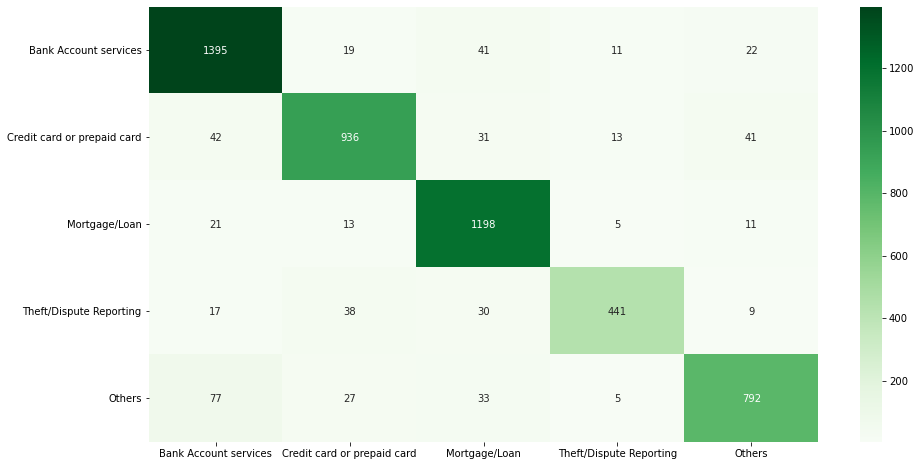


                             precision    recall  f1-score   support

      Bank Account services       0.90      0.94      0.92      1488
Credit card or prepaid card       0.91      0.88      0.89      1063
              Mortgage/Loan       0.90      0.96      0.93      1248
    Theft/Dispute Reporting       0.93      0.82      0.87       535
                     Others       0.91      0.85      0.88       934

                   accuracy                           0.90      5268
                  macro avg       0.91      0.89      0.90      5268
               weighted avg       0.90      0.90      0.90      5268


Accuracy: 90.39


In [50]:
#Logistic Regression

lr = LogisticRegression(solver="liblinear")
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

show_metrics(y_test, y_pred)

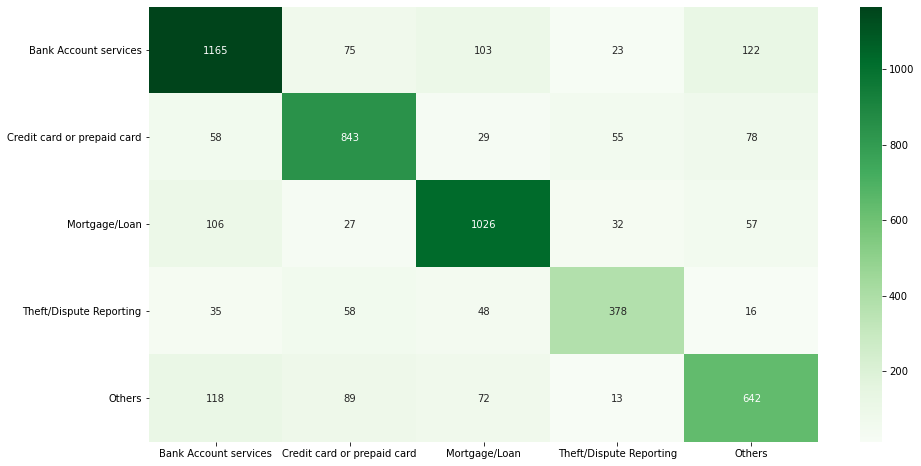


                             precision    recall  f1-score   support

      Bank Account services       0.79      0.78      0.78      1488
Credit card or prepaid card       0.77      0.79      0.78      1063
              Mortgage/Loan       0.80      0.82      0.81      1248
    Theft/Dispute Reporting       0.75      0.71      0.73       535
                     Others       0.70      0.69      0.69       934

                   accuracy                           0.77      5268
                  macro avg       0.76      0.76      0.76      5268
               weighted avg       0.77      0.77      0.77      5268


Accuracy: 76.96


In [51]:
#Decision Tree Classifier

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

show_metrics(y_test, y_pred)

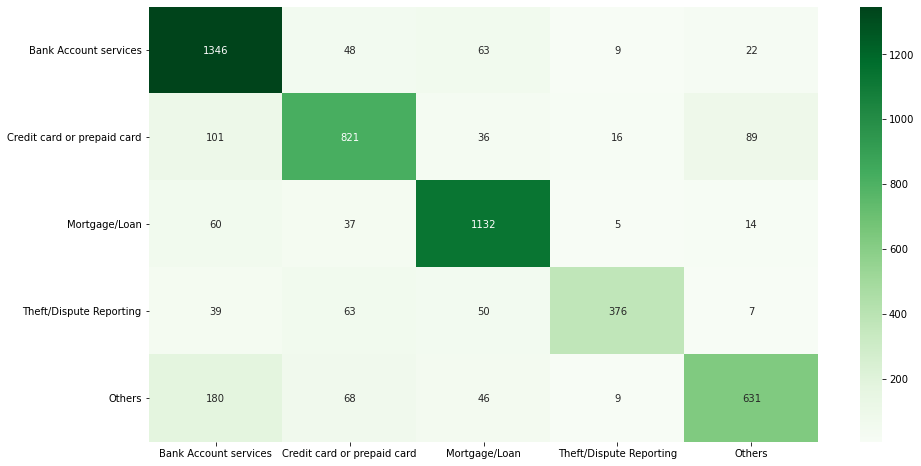


                             precision    recall  f1-score   support

      Bank Account services       0.78      0.90      0.84      1488
Credit card or prepaid card       0.79      0.77      0.78      1063
              Mortgage/Loan       0.85      0.91      0.88      1248
    Theft/Dispute Reporting       0.91      0.70      0.79       535
                     Others       0.83      0.68      0.74       934

                   accuracy                           0.82      5268
                  macro avg       0.83      0.79      0.81      5268
               weighted avg       0.82      0.82      0.81      5268


Accuracy: 81.74


In [52]:
#Random Forest Classifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

show_metrics(y_test, y_pred)

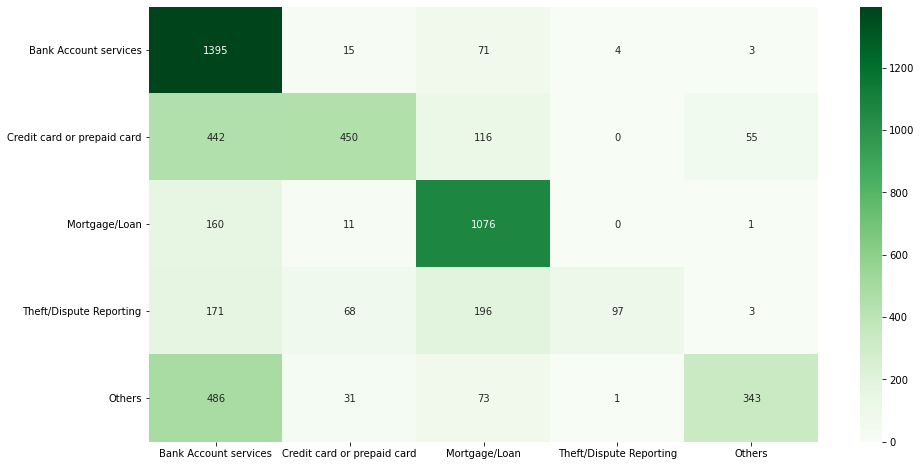


                             precision    recall  f1-score   support

      Bank Account services       0.53      0.94      0.67      1488
Credit card or prepaid card       0.78      0.42      0.55      1063
              Mortgage/Loan       0.70      0.86      0.77      1248
    Theft/Dispute Reporting       0.95      0.18      0.30       535
                     Others       0.85      0.37      0.51       934

                   accuracy                           0.64      5268
                  macro avg       0.76      0.55      0.56      5268
               weighted avg       0.72      0.64      0.61      5268


Accuracy: 63.8


In [53]:
#Naive Bayes Classifier

nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

show_metrics(y_test, y_pred)

## Conclusion

We see that the Logistic Regression model has the best accuracy. So it would make sense to use Logistic Regression for classification of future tickets. 